In [1]:
# ARIA Activity Recognition - LSTM Pipeline
# Reproducible LSTM training on sensor data sequences

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import polars as pl
from pathlib import Path
import json
import time
from tqdm.auto import tqdm

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.utils import to_categorical

# ML utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Experiment tracking
import wandb
wandb.init(project="aria-activity-recognition-lstm", mode="offline")
from wandb.integration.keras import WandbCallback

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"✅ TensorFlow version: {tf.__version__}")
print(f"✅ GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

2025-11-24 18:43:52.510701: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764009832.689265      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764009832.735112      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

wandb: Tracking run with wandb version 0.21.0
wandb: W&B syncing is set to `offline` in this directory. Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


✅ TensorFlow version: 2.18.0
✅ GPU Available: True


In [2]:
# ============================================================================
# CONFIGURATION
# ============================================================================
CONFIG = {
    'window_size': 256,
    'stride': 128,
    'use_subset': True,
    'subset_size': 1_000_000,
    'seed': SEED,
    
    # LSTM Architecture
    'lstm_units': [128, 64],  # Two LSTM layers
    'dropout_rate': 0.3,
    'recurrent_dropout': 0.2,
    'dense_units': 64,
    
    # Training
    'batch_size': 64,
    'epochs': 50,
    'learning_rate': 0.001,
    'patience': 10,  # Early stopping patience
    
    # Data
    'sensor_cols': ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'mag_x', 'mag_y', 'mag_z'],
    'test_size': 0.2,
    'val_size': 0.1  # From training set
}

print("✅ Configuration loaded")

✅ Configuration loaded


In [3]:
# ============================================================================
# DATA LOADING
# ============================================================================
def load_data(data_path="/kaggle/input", use_subset=True, subset_size=1_000_000):
    """Load and combine parquet files with labels - balanced by activity"""
    print("\n📂 Loading data...")
    
    # Kaggle paths
    data_dir = Path(data_path) / "data-loc"
    labels_path = Path(data_path) / "labels" / "labels.csv"
    
    # Load labels
    print(f"   Loading labels from: {labels_path}")
    labels_df = pl.read_csv(labels_path)
    
    # Load all parquet files
    all_dfs = []
    parquet_files = sorted(data_dir.glob("data_loc*.parquet"))
    print(f"   Found {len(parquet_files)} parquet files")
    
    for parquet_file in parquet_files:
        print(f"   Loading {parquet_file.name}...")
        all_dfs.append(pl.read_parquet(parquet_file))
    
    # Combine and join with labels
    print("   Combining dataframes...")
    combined_df = pl.concat(all_dfs)
    labeled_df = combined_df.join(labels_df, on=['script_id', 'sequence_id'], how='left')
    labeled_df = labeled_df.filter(pl.col('activity').is_not_null())
    
    print(f"   Total records: {len(labeled_df):,}")
    print(f"   Scripts: {sorted(labeled_df['script_id'].unique().to_list())}")
    
    # Get class distribution
    class_counts = labeled_df.group_by('activity').agg(pl.count().alias('count')).sort('activity')
    print("\n   📊 Original class distribution (5 activity types):")
    for row in class_counts.iter_rows(named=True):
        print(f"      {row['activity']:<30}: {row['count']:>10,} records")
    
    # Balanced subset by activity type
    if use_subset:
        print(f"\n   🎯 Creating balanced subset of {subset_size:,} records...")
        
        # Calculate samples per activity type for balanced dataset
        n_activities = labeled_df['activity'].n_unique()
        samples_per_activity = subset_size // n_activities
        
        print(f"   Target: {samples_per_activity:,} records per activity ({n_activities} activities)")
        
        # Sample from each activity class (reproducibly)
        balanced_dfs = []
        for activity in sorted(labeled_df['activity'].unique().to_list()):
            activity_df = labeled_df.filter(pl.col('activity') == activity)
            
            # Take up to samples_per_activity records
            n_samples = min(len(activity_df), samples_per_activity)
            
            # Reproducible sampling: sort by script_id, sequence_id, timestamp and take first n
            sampled = activity_df.sort(['script_id', 'sequence_id', 'timestamp']).head(n_samples)
            balanced_dfs.append(sampled)
            
            print(f"      {activity:<30}: {n_samples:>10,} records")
        
        labeled_df = pl.concat(balanced_dfs)
        
        # Shuffle the balanced dataset (with seed for reproducibility)
        labeled_df = labeled_df.sample(fraction=1.0, shuffle=True, seed=SEED)
        
        print(f"\n   ✅ Balanced subset created: {len(labeled_df):,} records")
    
    # Final class distribution
    final_counts = labeled_df.group_by('activity').agg(pl.count().alias('count')).sort('activity')
    print("\n   📊 Final balanced class distribution:")
    for row in final_counts.iter_rows(named=True):
        percentage = (row['count'] / len(labeled_df)) * 100
        print(f"      {row['activity']:<30}: {row['count']:>10,} ({percentage:>5.1f}%)")
    
    print(f"\n✅ Data loaded: {len(labeled_df):,} records, {labeled_df['activity'].n_unique()} activities")
    print(f"   Scripts used: {sorted(labeled_df['script_id'].unique().to_list())}")
    
    return labeled_df

In [4]:
# ============================================================================
# SEQUENCE CREATION FOR LSTM
# ============================================================================
def create_lstm_sequences(df, window_size, stride, sensor_cols):
    """
    Create sequences for LSTM input
    Returns: X (samples, timesteps, features), y (labels), metadata
    """
    print(f"\n🔄 Creating LSTM sequences (window={window_size}, stride={stride})...")
    
    X_list = []
    y_list = []
    metadata_list = []
    
    # Group by script and sequence
    groups = df.group_by(['script_id', 'sequence_id'])
    
    for (script_id, sequence_id), group_data in tqdm(groups, desc="Processing sequences"):
        group_data = group_data.sort('timestamp')
        
        # Skip if sequence too short
        if len(group_data) < window_size:
            continue
        
        # Extract sensor data and activity
        sensor_data = group_data.select(sensor_cols).to_numpy()
        activity = group_data['activity'][0]  # Activity is same for entire sequence
        
        # Create sliding windows
        for start_idx in range(0, len(group_data) - window_size + 1, stride):
            window = sensor_data[start_idx:start_idx + window_size]
            
            X_list.append(window)
            y_list.append(activity)
            metadata_list.append({
                'script_id': script_id,
                'sequence_id': sequence_id,
                'start_idx': start_idx
            })
    
    X = np.array(X_list, dtype=np.float32)
    y = np.array(y_list)
    
    print(f"✅ Created {len(X):,} sequences")
    print(f"   Shape: {X.shape} (samples, timesteps, features)")
    
    return X, y, metadata_list

In [5]:
# ============================================================================
# DATA PREPROCESSING
# ============================================================================
def preprocess_data(X, y, test_size=0.2, val_size=0.1, seed=42):
    """
    Normalize data and create train/val/test splits
    """
    print("\n⚙️ Preprocessing data...")
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    n_classes = len(label_encoder.classes_)
    
    print(f"   Classes: {label_encoder.classes_}")
    print(f"   Class distribution: {dict(zip(*np.unique(y_encoded, return_counts=True)))}")
    
    # Train/test split (stratified)
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y_encoded, test_size=test_size, stratify=y_encoded, random_state=seed
    )
    
    # Train/val split
    val_size_adjusted = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size_adjusted, 
        stratify=y_train_val, random_state=seed
    )
    
    # Normalize data (fit on training data only)
    # Reshape for scaling: (samples * timesteps, features)
    n_samples, n_timesteps, n_features = X_train.shape
    
    scaler = StandardScaler()
    X_train_reshaped = X_train.reshape(-1, n_features)
    scaler.fit(X_train_reshaped)
    
    # Transform all sets
    X_train = scaler.transform(X_train.reshape(-1, n_features)).reshape(n_samples, n_timesteps, n_features)
    X_val = scaler.transform(X_val.reshape(-1, n_features)).reshape(X_val.shape[0], n_timesteps, n_features)
    X_test = scaler.transform(X_test.reshape(-1, n_features)).reshape(X_test.shape[0], n_timesteps, n_features)
    
    # Convert labels to categorical
    y_train_cat = to_categorical(y_train, n_classes)
    y_val_cat = to_categorical(y_val, n_classes)
    y_test_cat = to_categorical(y_test, n_classes)
    
    print(f"✅ Preprocessing complete")
    print(f"   Train: {X_train.shape[0]:,} samples")
    print(f"   Val:   {X_val.shape[0]:,} samples")
    print(f"   Test:  {X_test.shape[0]:,} samples")
    
    return {
        'X_train': X_train, 'y_train': y_train, 'y_train_cat': y_train_cat,
        'X_val': X_val, 'y_val': y_val, 'y_val_cat': y_val_cat,
        'X_test': X_test, 'y_test': y_test, 'y_test_cat': y_test_cat,
        'scaler': scaler,
        'label_encoder': label_encoder,
        'n_classes': n_classes
    }

In [6]:
# ============================================================================
# LSTM MODEL ARCHITECTURE
# ============================================================================
def build_lstm_model(input_shape, n_classes, config):
    """
    Build robust LSTM model for activity recognition
    """
    print("\n🏗️ Building LSTM model...")
    
    model = keras.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # First LSTM layer (return sequences for stacking)
        layers.LSTM(
            config['lstm_units'][0],
            return_sequences=True,
            dropout=config['dropout_rate'],
            recurrent_dropout=config['recurrent_dropout'],
            name='lstm_1'
        ),
        layers.BatchNormalization(),
        
        # Second LSTM layer
        layers.LSTM(
            config['lstm_units'][1],
            return_sequences=False,
            dropout=config['dropout_rate'],
            recurrent_dropout=config['recurrent_dropout'],
            name='lstm_2'
        ),
        layers.BatchNormalization(),
        
        # Dense layers
        layers.Dense(config['dense_units'], activation='relu', name='dense_1'),
        layers.Dropout(config['dropout_rate']),
        
        # Output layer
        layers.Dense(n_classes, activation='softmax', name='output')
    ])
    
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=config['learning_rate']),
        loss='categorical_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(name='auc')]
    )
    
    print("✅ Model architecture:")
    model.summary()
    
    return model

In [7]:
# ============================================================================
# TRAINING
# ============================================================================
def train_model(model, data, config, run_name=None, use_wandb=False):
    """
    Train LSTM model with callbacks and monitoring
    """
    print("\n🚀 Training model...")

    # -----------------------------
    # W&B initialization (optional)
    # -----------------------------
    callback_list = []

    if use_wandb:
        import wandb
        from wandb.integration.keras import WandbCallback
        # offline mode avoids API key issues
        wandb.init(
            project='aria-activity-recognition-lstm',
            name=run_name,
            config={**config, 'model_type': 'LSTM'},
            tags=['lstm', 'keras', 'activity-recognition'],
            mode="offline"
        )
        callback_list.append(
            WandbCallback(monitor='val_loss', save_model=False)
        )

    # -----------------------------
    # Keras callbacks
    # -----------------------------
    from tensorflow.keras import callbacks

    callback_list.extend([
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=config['patience'],
            restore_best_weights=True,
            verbose=1
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        callbacks.ModelCheckpoint(
            'best_lstm_model.keras',
            monitor='val_loss',
            save_best_only=True,
            verbose=0
        )
    ])

    # -----------------------------
    # Class weights for imbalance
    # -----------------------------
    class_counts = np.bincount(data['y_train'])
    class_weights = {i: len(data['y_train']) / (len(class_counts) * count) 
                     for i, count in enumerate(class_counts)}

    print(f"   Class weights: {class_weights}")

    # -----------------------------
    # Train
    # -----------------------------
    start_time = time.time()
    history = model.fit(
        data['X_train'], data['y_train_cat'],
        validation_data=(data['X_val'], data['y_val_cat']),
        epochs=config['epochs'],
        batch_size=config['batch_size'],
        class_weight=class_weights,
        callbacks=callback_list,
        verbose=1
    )
    training_time = time.time() - start_time

    print(f"✅ Training complete: {training_time/60:.1f} minutes")

    return history, training_time


In [8]:
# ============================================================================
# EVALUATION
# ============================================================================
def evaluate_model(model, data, label_encoder):
    """
    Comprehensive model evaluation
    """
    print("\n📊 Evaluating model...")
    
    # Predictions
    y_pred_probs = model.predict(data['X_test'], verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = data['y_test']
    
    # Metrics
    test_acc = accuracy_score(y_true, y_pred)
    test_f1_macro = f1_score(y_true, y_pred, average='macro')
    test_f1_weighted = f1_score(y_true, y_pred, average='weighted')
    
    print(f"🎯 Test Accuracy: {test_acc:.4f}")
    print(f"🎯 Test F1-Macro: {test_f1_macro:.4f}")
    print(f"🎯 Test F1-Weighted: {test_f1_weighted:.4f}")
    
    # Classification report
    print("\n📋 Classification Report:")
    report = classification_report(
        y_true, y_pred,
        target_names=label_encoder.classes_,
        digits=4
    )
    print(report)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Log to W&B
    wandb.log({
        'test_accuracy': test_acc,
        'test_f1_macro': test_f1_macro,
        'test_f1_weighted': test_f1_weighted
    })
    
    # Per-class metrics
    class_report = classification_report(
        y_true, y_pred,
        target_names=label_encoder.classes_,
        output_dict=True,
        zero_division=0
    )
    
    per_class_data = []
    for activity in label_encoder.classes_:
        if activity in class_report:
            metrics = class_report[activity]
            per_class_data.append({
                'activity': activity,
                'precision': metrics['precision'],
                'recall': metrics['recall'],
                'f1_score': metrics['f1-score'],
                'support': int(metrics['support'])
            })
    
    wandb.log({'per_class_metrics': wandb.Table(dataframe=pd.DataFrame(per_class_data))})
    
    return {
        'accuracy': test_acc,
        'f1_macro': test_f1_macro,
        'f1_weighted': test_f1_weighted,
        'confusion_matrix': cm,
        'predictions': y_pred,
        'probabilities': y_pred_probs
    }

In [9]:
# ============================================================================
# VISUALIZATION
# ============================================================================
def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Loss
    axes[1].plot(history.history['loss'], label='Train', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation', linewidth=2)
    axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # AUC
    if 'auc' in history.history:
        axes[2].plot(history.history['auc'], label='Train', linewidth=2)
        axes[2].plot(history.history['val_auc'], label='Validation', linewidth=2)
        axes[2].set_title('Model AUC', fontsize=14, fontweight='bold')
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel('AUC')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    wandb.log({"training_history": wandb.Image('training_history.png')})
    plt.show()

def plot_confusion_matrix(cm, class_names):
    """Plot confusion matrix"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix - LSTM Model', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Activity', fontsize=12)
    plt.ylabel('True Activity', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('confusion_matrix_lstm.png', dpi=300, bbox_inches='tight')
    wandb.log({"confusion_matrix": wandb.Image('confusion_matrix_lstm.png')})
    plt.show()

In [10]:
# ============================================================================
# SAVE ARTIFACTS
# ============================================================================
def save_artifacts(model, scaler, label_encoder, config, metrics):
    """Save trained model and metadata"""
    print("\n💾 Saving artifacts...")
    
    artifacts_dir = Path("lstm_artifacts")
    artifacts_dir.mkdir(exist_ok=True)
    
    # Save model
    model.save(artifacts_dir / "lstm_model.keras")
    
    # Save preprocessors
    import joblib
    joblib.dump(scaler, artifacts_dir / "scaler.pkl")
    joblib.dump(label_encoder, artifacts_dir / "label_encoder.pkl")
    
    # Save metadata
    metadata = {
        'model_type': 'LSTM',
        'test_accuracy': float(metrics['accuracy']),
        'test_f1_macro': float(metrics['f1_macro']),
        'test_f1_weighted': float(metrics['f1_weighted']),
        'config': config,
        'input_shape': model.input_shape[1:],
        'n_classes': len(label_encoder.classes_),
        'classes': label_encoder.classes_.tolist()
    }
    
    with open(artifacts_dir / "metadata.json", 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"✅ Artifacts saved to: {artifacts_dir}")
    
    # Upload to W&B
    wandb.save(str(artifacts_dir / "lstm_model.keras"))
    wandb.save(str(artifacts_dir / "metadata.json"))

In [11]:
# ============================================================================
# MAIN PIPELINE
# ============================================================================
def main():
    """Execute full LSTM training pipeline"""
    print("="*80)
    print("ARIA ACTIVITY RECOGNITION - LSTM PIPELINE")
    print("="*80)
    
    # 1. Load data
    df = load_data(
        data_path="/kaggle/input",
        use_subset=CONFIG['use_subset'],
        subset_size=CONFIG['subset_size']
    )
    
    # 2. Create sequences
    X, y, metadata = create_lstm_sequences(
        df,
        window_size=CONFIG['window_size'],
        stride=CONFIG['stride'],
        sensor_cols=CONFIG['sensor_cols']
    )
    
    # 3. Preprocess
    data = preprocess_data(
        X, y,
        test_size=CONFIG['test_size'],
        val_size=CONFIG['val_size'],
        seed=CONFIG['seed']
    )
    
    # 4. Build model
    input_shape = (CONFIG['window_size'], len(CONFIG['sensor_cols']))
    model = build_lstm_model(input_shape, data['n_classes'], CONFIG)
    
    # 5. Train
    history, training_time = train_model(model, data, CONFIG)
    
    # 6. Evaluate
    metrics = evaluate_model(model, data, data['label_encoder'])
    
    # 7. Visualize
    plot_training_history(history)
    plot_confusion_matrix(metrics['confusion_matrix'], data['label_encoder'].classes_)
    
    # 8. Save
    save_artifacts(model, data['scaler'], data['label_encoder'], CONFIG, metrics)
    
    # Final summary
    print("\n" + "="*80)
    print("TRAINING COMPLETE!")
    print("="*80)
    print(f"🎯 Test Accuracy: {metrics['accuracy']:.4f}")
    print(f"🎯 Test F1-Macro: {metrics['f1_macro']:.4f}")
    print(f"⏱️  Training Time: {training_time/60:.1f} minutes")
    print("="*80)
    
    wandb.finish()

ARIA ACTIVITY RECOGNITION - LSTM PIPELINE

📂 Loading data...
   Loading labels from: /kaggle/input/labels/labels.csv
   Found 5 parquet files
   Loading data_loc1.parquet...
   Loading data_loc2.parquet...
   Loading data_loc3.parquet...
   Loading data_loc4.parquet...
   Loading data_loc5.parquet...
   Combining dataframes...
   Total records: 49,259,469
   Scripts: [1, 2, 3, 4, 5]

   📊 Original class distribution (5 activity types):
      Caffeination                  :  2,024,918 records
      Catch up on what happened     :  1,892,968 records
      Check the food provisions     :  1,199,652 records
      Clean a spill                 :    803,252 records
      Clean the place               :  1,741,591 records
      Clean up                      :  2,578,509 records
      Cooking                       :  3,247,180 records
      Dry your clothes              :    530,392 records
      Eating                        :  2,097,318 records
      Food and accomodations        :  1,045,03

Processing sequences: 0it [00:00, ?it/s]

✅ Created 7,755 sequences
   Shape: (7755, 256, 9) (samples, timesteps, features)

⚙️ Preprocessing data...
   Classes: ['Caffeination' 'Catch up on what happened' 'Check the food provisions'
 'Clean a spill' 'Clean the place' 'Clean up' 'Cooking' 'Dry your clothes'
 'Eating' 'Food and accomodations' 'Friends arrives at home'
 'Get and fold the laundry' 'Get home' 'Grab cream, sugar and snacks'
 'Health activity' 'Morning exercise' 'Perk up with coffee'
 'Play a board game' 'Prepare breakfast' 'Read and wait' 'Relaxing'
 'Room Decoration' 'Set the table and eat' 'Share some vides'
 'Straighten up' 'Talk about the day' 'Texting and Reading'
 'The home tour' 'Time to go' 'Video game break' 'Waking up'
 'Wash the clothes' 'Watch TV']
   Class distribution: {0: 235, 1: 235, 2: 235, 3: 235, 4: 235, 5: 235, 6: 235, 7: 235, 8: 235, 9: 235, 10: 235, 11: 235, 12: 235, 13: 235, 14: 235, 15: 235, 16: 235, 17: 235, 18: 235, 19: 235, 20: 235, 21: 235, 22: 235, 23: 235, 24: 235, 25: 235, 26: 235, 27

I0000 00:00:1764009880.169824      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764009880.170765      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


✅ Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 256, 128)       │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 33)             │         2,145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,137 (496.63 KB)

 Trainable params: 126,753 (495.13 KB)

 Non-trainable params: 384 (1.50 KB)


🚀 Training model...
   Class weights: {0: 0.9968778696051424, 1: 1.0029563932002956, 2: 1.0029563932002956, 3: 1.0029563932002956, 4: 0.9968778696051424, 5: 0.9968778696051424, 6: 1.0029563932002956, 7: 1.0029563932002956, 8: 0.9968778696051424, 9: 0.9968778696051424, 10: 1.0029563932002956, 11: 0.9968778696051424, 12: 0.9968778696051424, 13: 0.9968778696051424, 14: 1.0029563932002956, 15: 0.9968778696051424, 16: 0.9968778696051424, 17: 0.9968778696051424, 18: 1.0029563932002956, 19: 0.9968778696051424, 20: 1.0029563932002956, 21: 0.9968778696051424, 22: 1.0029563932002956, 23: 1.0029563932002956, 24: 0.9968778696051424, 25: 1.0029563932002956, 26: 0.9968778696051424, 27: 1.0029563932002956, 28: 1.0029563932002956, 29: 1.0029563932002956, 30: 1.0029563932002956, 31: 0.9968778696051424, 32: 1.0029563932002956}
Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.0463 - auc: 0.5547 - loss: 3.6900 - val_accuracy: 0.0863 - val_auc: 0.6854 - val_loss: 3.3821 - learning_rate: 0.

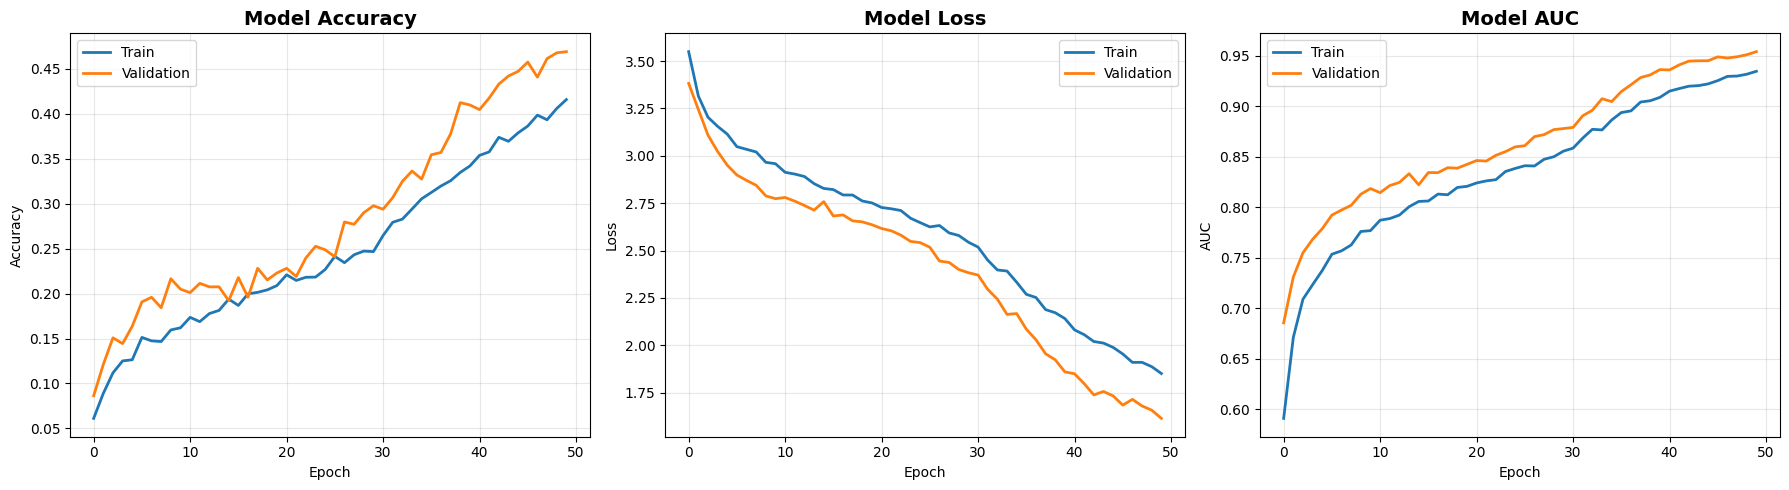

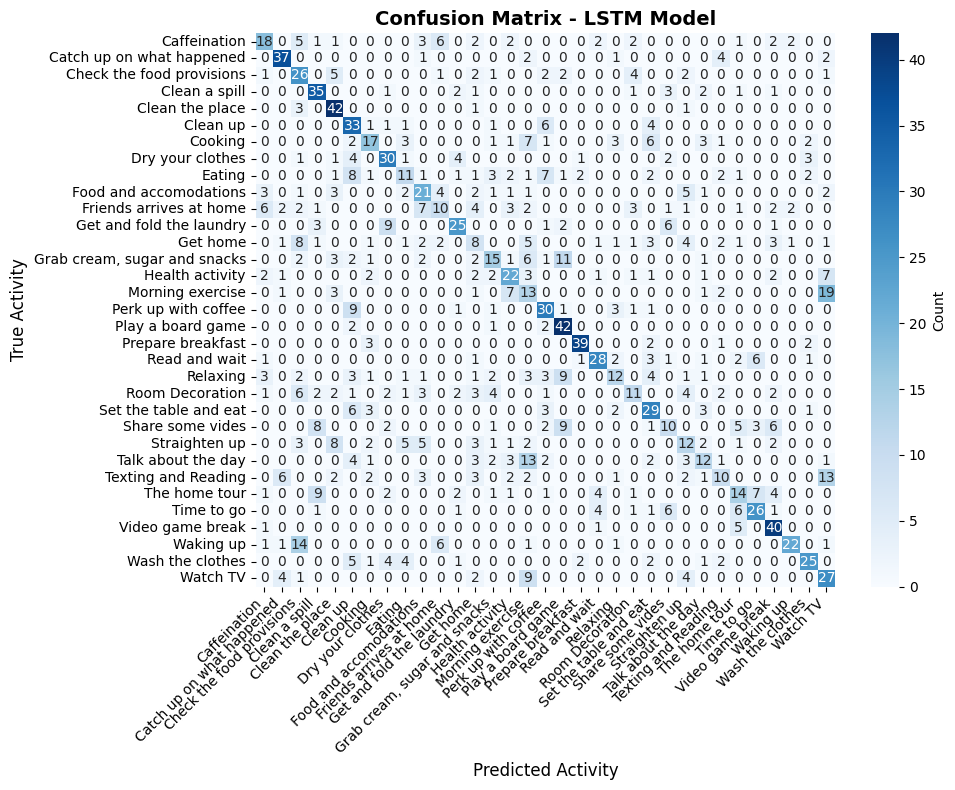

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:    test_accuracy ▁
wandb:    test_f1_macro ▁
wandb: test_f1_weighted ▁
wandb: 
wandb: Run summary:
wandb:    test_accuracy 0.48485
wandb:    test_f1_macro 0.47174
wandb: test_f1_weighted 0.47174
wandb: 
wandb: You can sync this run to the cloud by running:
wandb: wandb sync /kaggle/working/wandb/offline-run-20251124_184410-7uxab05y
wandb: Find logs at: ./wandb/offline-run-20251124_184410-7uxab05y/logs



💾 Saving artifacts...
✅ Artifacts saved to: lstm_artifacts

TRAINING COMPLETE!
🎯 Test Accuracy: 0.4848
🎯 Test F1-Macro: 0.4717
⏱️  Training Time: 92.6 minutes


In [12]:
# ============================================================================
# RUN
# ============================================================================
if __name__ == "__main__":
    main()